# Hour Detection

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

#my functions
from Plot import plot_cv, plot_img

In [32]:
path = '../../../Data/data-resampled/clock_0201.png'
img = cv.imread(path, cv.IMREAD_COLOR_RGB)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img.shape

(500, 800, 3)

## Clean and Found the Clock

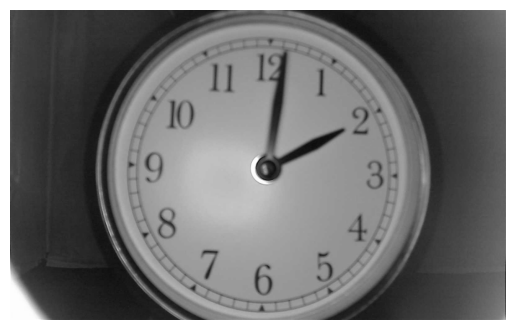

In [33]:
plot_img(img)

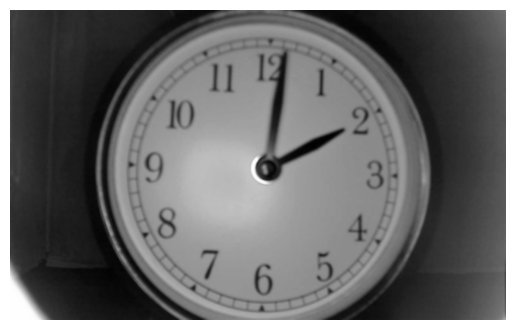

In [34]:
blurred_img = cv.GaussianBlur(gray, (5,5), 0)
plot_img(blurred_img)

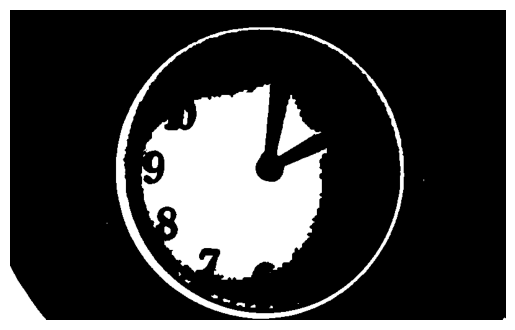

In [35]:
_, thres_img = cv.threshold(blurred_img , 155.8, 255, cv.THRESH_BINARY)
plot_img(thres_img)

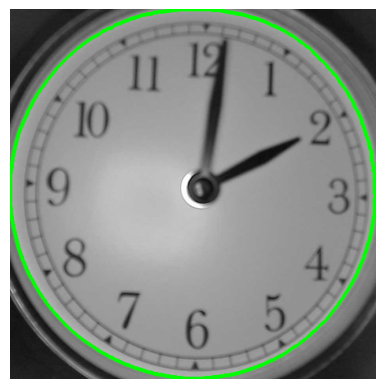

In [36]:
contours, _ = cv.findContours(thres_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

center_contour = max(contours, key=cv.contourArea)

x, y, w, h = cv.boundingRect(center_contour)
clock = img[y:y+h, x:x+w].copy()  #to use 
circled = img[y:y+h, x:x+w].copy()  #to show

clock = cv.cvtColor(clock, cv.COLOR_RGB2GRAY)

c_shifted = center_contour - [x, y]
cv.drawContours(circled, [c_shifted], -1, (0, 255, 0), 3)

plot_img(circled)

## Threshold the Clock

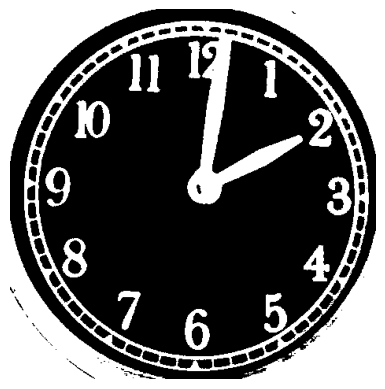

In [37]:
_, clock_thres = cv.threshold(clock , 135, 255, cv.THRESH_BINARY)
clock_thres = cv.bitwise_not(clock_thres)
plot_img(clock_thres)

In [38]:
def get_center(img):
    xs, ys = [], []
    M, N = img.shape

    for i in range(M):
        for j in range(N):
            if img[i, j] != 0:
                xs.append(i)
                ys.append(j) 
    return xs, ys

In [39]:
xs, ys = get_center(clock)
center_x = int(np.mean(xs))
center_y = int(np.mean(ys))
center_x, center_y

(234, 232)

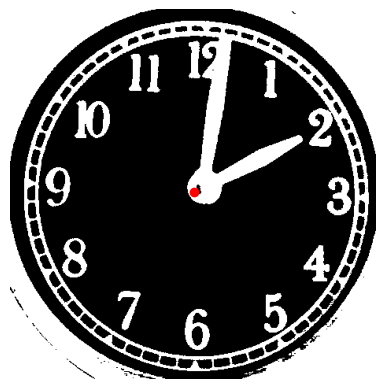

In [40]:
plt.imshow(clock_thres, cmap = plt.cm.gray)
plt.plot(center_x, center_y, 'ro')
plt.axis('off')
plt.show()

In [41]:
def get_radius(contours, center_x, center_y, point_index):
    if point_index > len(contours[0]):
        raise IndexError("Out limits")
    
    point = contours[0][point_index][0] 
    r = np.sqrt((center_x - point[0])**2 + (center_y - point[1])**2)
    return r, point


In [42]:
r, point = get_radius([c_shifted], center_x, center_y, 0)
r

np.float64(232.86047324524614)

In [43]:
print(center_x-point[0], center_y -point[1])

20 232


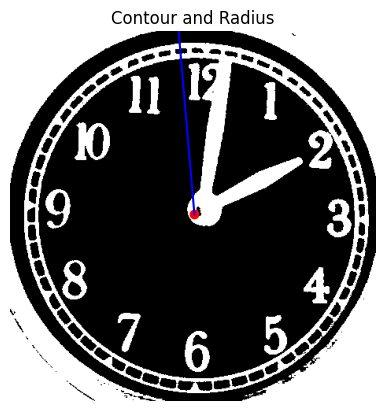

In [44]:
plt.imshow(clock_thres, cmap=plt.cm.gray)
plt.plot(center_x, center_y, 'ro') 

plt.plot([center_x, point[0]], [center_y, point[1]], 'b-') 
plt.title("Contour and Radius")
plt.axis('off')
plt.show()

## Search Hands on the Clock

In [45]:
amount_lines = 20

In [46]:
def detect_hands_lengths(img_bin, cx, cy, radius, amount_lines=2, start_skip=5, gap_tol=3):
    h, w = img_bin.shape
    results = []

    for ang in range(0, 360, 1):
        theta = math.radians(ang) #degree to radian
        white = 0 #amount of white pixels
        black = 0 #black pixels
        seen_wht = False 

        for r in range(start_skip, radius):
            x = int(round(cx + r * math.cos(theta)))
            y = int(round(cy + r * math.sin(theta)))
            if not (0 <= x < w and 0 <= y < h):
                break

            if img_bin[y, x] == 255:
                seen_wht = True
                white += 1
                black = 0
            else:
                if seen_wht:
                    black += 1
                    if black >= gap_tol:
                        break
        
        length = white
        results.append((length, ang))

    results.sort(reverse=True, key=lambda t: t[0])
    return results[:amount_lines] #(length, angle)

In [47]:
hands23 = detect_hands_lengths(clock_thres, center_x, center_y, int(r), amount_lines)
hands23.sort(key = lambda x: x[1])
for length, ang in hands23:
    print(f"Length in pixels: {length}, Angle: {ang:.1f}°")

Length in pixels: 201, Angle: 283.0°
Length in pixels: 188, Angle: 284.0°
Length in pixels: 167, Angle: 285.0°
Length in pixels: 146, Angle: 286.0°
Length in pixels: 132, Angle: 287.0°
Length in pixels: 120, Angle: 288.0°
Length in pixels: 111, Angle: 289.0°
Length in pixels: 97, Angle: 290.0°
Length in pixels: 102, Angle: 328.0°
Length in pixels: 112, Angle: 329.0°
Length in pixels: 123, Angle: 330.0°
Length in pixels: 138, Angle: 331.0°
Length in pixels: 144, Angle: 332.0°
Length in pixels: 145, Angle: 333.0°
Length in pixels: 144, Angle: 334.0°
Length in pixels: 141, Angle: 335.0°
Length in pixels: 126, Angle: 336.0°
Length in pixels: 113, Angle: 337.0°
Length in pixels: 103, Angle: 338.0°
Length in pixels: 94, Angle: 339.0°


In [48]:
def draw_hands(img, cx, cy, hands, r):  
    out = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

    for count, angle in hands:
        limited_r = min(r, count)  

        theta = math.radians(angle)
        x_end = int(cx + limited_r * math.cos(theta))
        y_end = int(cy + limited_r * math.sin(theta))

        cv.line(out, (cx, cy), (x_end, y_end), (255, 0, 0), 2)

    return out

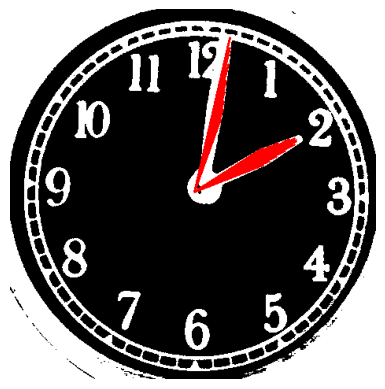

In [49]:
img_hands = draw_hands(clock_thres, center_x, center_y, hands23, r)
plot_img(img_hands)

In [50]:
plot_cv(img_hands)

## Cluster The Possible Hands by Angles

In [51]:
def cluster_by_angle(canditates, interval_deg=10):
    if not canditates:
        return []

    cands = sorted(canditates, key=lambda t: t[1])

    clusters = []
    cur = [cands[0]]
    last_angle = cands[0][1]

    for length, angle in cands[1:]:
        if (angle - last_angle) <= interval_deg:
            cur.append((length, angle))
        else:
            clusters.append(cur)
            cur = [(length, angle)]
        last_angle = angle

    clusters.append(cur)

    return clusters #(length, angle)

In [52]:
clusters = cluster_by_angle(hands23)
clusters

[[(201, 283),
  (188, 284),
  (167, 285),
  (146, 286),
  (132, 287),
  (120, 288),
  (111, 289),
  (97, 290)],
 [(102, 328),
  (112, 329),
  (123, 330),
  (138, 331),
  (144, 332),
  (145, 333),
  (144, 334),
  (141, 335),
  (126, 336),
  (113, 337),
  (103, 338),
  (94, 339)]]

In [53]:
def pick_biggest(cluster):
    #cluster = (length, angle)
    reps = []
    for group in cluster: 
        best = max(group, key = lambda x: x[0]) #pick the length
        angles = [a for _, a in group]
        reps.append({
            "angle": best[1] % 360.0,
            "length": best[0],
            "count": len(group),
            "min_angle": min(angles) % 360.0,
            "max_angle": max(angles) % 360.0,
        })
    return reps

In [54]:
values = pick_biggest(clusters)
values

[{'angle': 283.0,
  'length': 201,
  'count': 8,
  'min_angle': 283.0,
  'max_angle': 290.0},
 {'angle': 333.0,
  'length': 145,
  'count': 12,
  'min_angle': 328.0,
  'max_angle': 339.0}]

In [55]:
def draw_hands_on_image(img, cx, cy, reps, start_skip=5, thickness=3):
    out_img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    palette = [(0, 0, 255), (255, 0, 0)] #red and blue

    for i, d in enumerate(reps):
        ang = float(d["angle"])
        L = int(d["length"])
        L_draw = L + int(start_skip)

        theta = math.radians(ang)
        xe = int(round(cx + L_draw * math.cos(theta)))
        ye = int(round(cy + L_draw * math.sin(theta)))

        color = palette[i % len(palette)]
        cv.line(out_img, (int(cx), int(cy)), (xe, ye), color, thickness, cv.LINE_AA)
        cv.circle(out_img, (xe, ye), 4, color, -1, cv.LINE_AA) #end line

    cv.circle(out_img, (int(cx), int(cy)), 8, (255, 255, 255), -1, cv.LINE_AA) #center circle
    return out_img

In [56]:
overlay = draw_hands_on_image(clock_thres, center_x, center_y, values)

In [57]:
def get_time(reps):
    if not reps or len(reps) < 2:
        return None, None

    a, b = sorted(reps, key=lambda d: d["length"], reverse=True)
    minute_rep = a["angle"]
    hour_rep = b["angle"]

    phiM = (float(minute_rep) + 90.0) % 360.0
    phiH = (float(hour_rep) + 90.0) % 360.0

    #minutes 
    M = int(round(phiM / 6.0)) % 60

    #hour
    hour_float = ((phiH - 0.5 * M) / 30.0) % 12.0
    H = int(round(hour_float)) % 12
    H = 12 if H == 0 else H

    return H, M

In [58]:
H, M = get_time(values)
print(f"{H:02d}:{M:02d}")

02:02


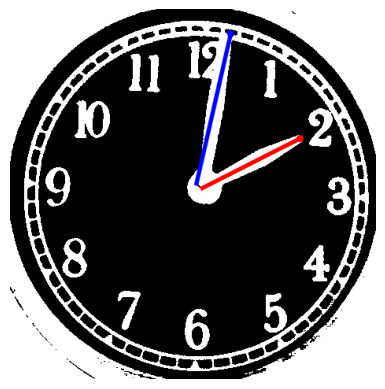

In [59]:
plot_img(overlay)

In [60]:
plot_cv(overlay)